# Module 2 Project

## 1st Hypotheses 

## Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

### Null Hypothesis: discounts have no effect on the # of products that customer's order

### Alternate Hypothesis: discounts do effect the # of products that customer's order
(2-tailed test)

In [1]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Getting The Right Info (SQL)

In [2]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

engine = create_engine("sqlite:///Northwind_small.sqlite")
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)

In [3]:
# Get names of tables in database
print(inspector.get_table_names())

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [4]:
nodiscount_df = pd.read_sql_query("Select ProductId, SUM(Quantity) total from OrderDetail where Discount = 0 group by ProductId", engine)
nodiscount_df.head()

,ProductId,total
0,1,391
1,2,408
2,3,288
3,4,172
4,5,176


In [5]:
discount_df = pd.read_sql_query("Select ProductId, SUM(Quantity) total from OrderDetail where Discount > 0 group by ProductId", engine)
discount_df.head()

,ProductId,total
0,1,437
1,2,649
2,3,40
3,4,281
4,5,122


## Prepping the Data for the Hypothesis Testing Using Pandas

In [6]:
nodiscount = np.array(nodiscount_df.total)
discount = np.array(discount_df.total)

In [7]:
difference = discount-nodiscount
difference

array([  46,  241, -248,  109,  -54, -127, -493, -108,   77, -114,  -50,
       -106, -221,  -80,  -48,  224,   58,   15, -115,    5, -144, -296,
       -184, -283,   68,  -61, -335,  -98, -100,  -26,  233,   75, -283,
        -32, -179, -183,   31,  -17,  107,  -41, -217,   55, -170,  151,
         68, -172,  -87,   90, -236, -115,    2, -208, -156, -149,  449,
       -279, -316,  272, -154,   47,  219, -347, -135, -260,   83,  -99,
        -46, -277,  122,  -59, -251, -414,  -61, -155, -107, -201,  -31],
      dtype=int64)

#### Because we are comparing a mean change of 0 (null hypothesis) vs the actual change observed in products sold by product, discount vs no discount, I think we need to do a 1 sample t-test

## Hypothesis Test Begins

### Null Hypo: mu = 0
### Alt Hypo: mu != 0
alpha = .05

In [8]:
n = difference.size
dfr = n-1

### Visualize Sample Distribution

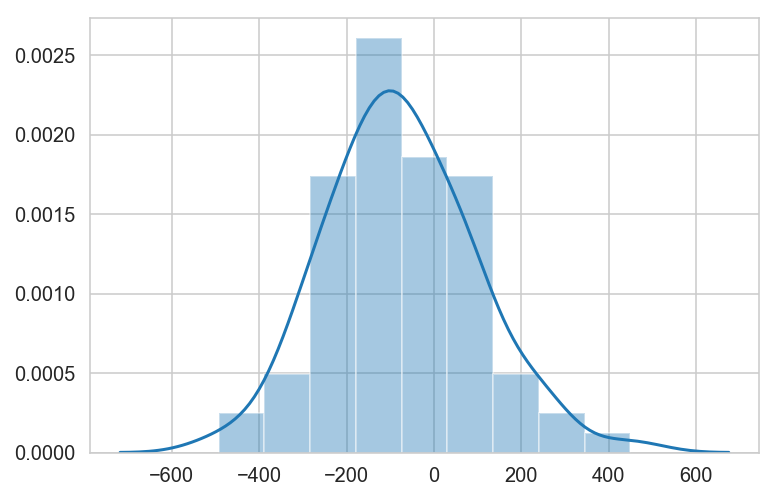

In [9]:
sns.distplot(difference)

The T-Test needs the data to be normally distributed to be reliable.  From this histogram, it is clear we are able to meet that assumption

### Results:

In [10]:
results = stats.ttest_1samp(a= difference, popmean= 0)         
print ("The t-value for our sample is", round(results[0], 2), "and the p-value is", np.round((results[1]), 4))

The t-value for our sample is -3.96 and the p-value is 0.0002


In [11]:
t_crit = np.round(stats.t.ppf(1 - 0.025, df=dfr),3)
t_crit

1.992

Our t-critical value for this 2-tailed test is plus or minus 1.992.  Since our t-value of -3.96 is less than -1.992 we reject the null hypothesis that discounts have no significant effect on product sales.  And our negative t-value tells us that we actually saw, in the data, statistically significant evidence that discounts were associated with fewer raw sale numbers

To me this result is surprising. One would generally assume that people would generally rather buy a product that is less expensive vs. the same product that is listed at a more expensive price.  This makes me call into question the validity of this hypothesis.  One thing that immediately raises a red flag is that with this test, we had no idea how long each product was offered at full price vs. discounted price.  Each product could have been discounted 1 month of the year and at full price the other 11 months.  Even if the discount resulted in more sales per month, overall sales would almost always still favor the full price item due to time advantage.

So I don't think we should pay any mind to the results of this hypothesis test.  To truly try to gauge success of discounted prices, one would have to devise a test that examined sales rates (time factored in) rather than raw sales numbers over an unidentified period of time

# 2nd Hypothesis

### Topic - Younger vs Older employees sales numbers

#### SQL Query

In [12]:
df = pd.read_sql_query("""
Select o.Id OrderId, o.EmployeeId, o.OrderDate, e.LastName, e.FirstName, e.BirthDate, count(*) num_orders 
from [Order] o JOIN Employee e on o.EmployeeId = e.Id where o.OrderDate between '2013-01-01' and '2015-01-01' 
group by o.EmployeeId
order by e.Birthdate
""", engine)
df

,OrderId,EmployeeId,OrderDate,LastName,FirstName,BirthDate,num_orders
0,10403,4,2013-01-03,Peacock,Margaret,1969-09-19,125
1,10400,1,2013-01-01,Davolio,Nancy,1980-12-08,97
2,10404,2,2013-01-03,Fuller,Andrew,1984-02-19,80
3,10463,5,2013-03-04,Buchanan,Steven,1987-03-04,31
4,10402,8,2013-01-02,Callahan,Laura,1990-01-09,85
5,10406,7,2013-01-07,King,Robert,1992-05-29,61
6,10423,6,2013-01-23,Suyama,Michael,1995-07-02,52
7,10409,3,2013-01-09,Leverling,Janet,1995-08-30,109
8,10411,9,2013-01-10,Dodsworth,Anne,1998-01-27,38


### Is there a statistically significant difference between sales rates of the lower 50 percentile of employees vs the upper 50 percentile of employees (age)?  

This test measures over a 2 calendar year period.  We are using raw number of orders as the measure of sales in this test

### Null Hypo: no difference between sales rates of older vs younger sales employees

### Alternative: there is a difference between the two

(2-tailed test), alpha=.05

In [13]:
young = np.array(df.num_orders.iloc[0:4])
old = np.array(df.num_orders.iloc[5:])

In [14]:
young

array([125,  97,  80,  31], dtype=int64)

In [15]:
old

array([ 61,  52, 109,  38], dtype=int64)

In [16]:
young.mean(), old.mean()

(83.25, 65.0)

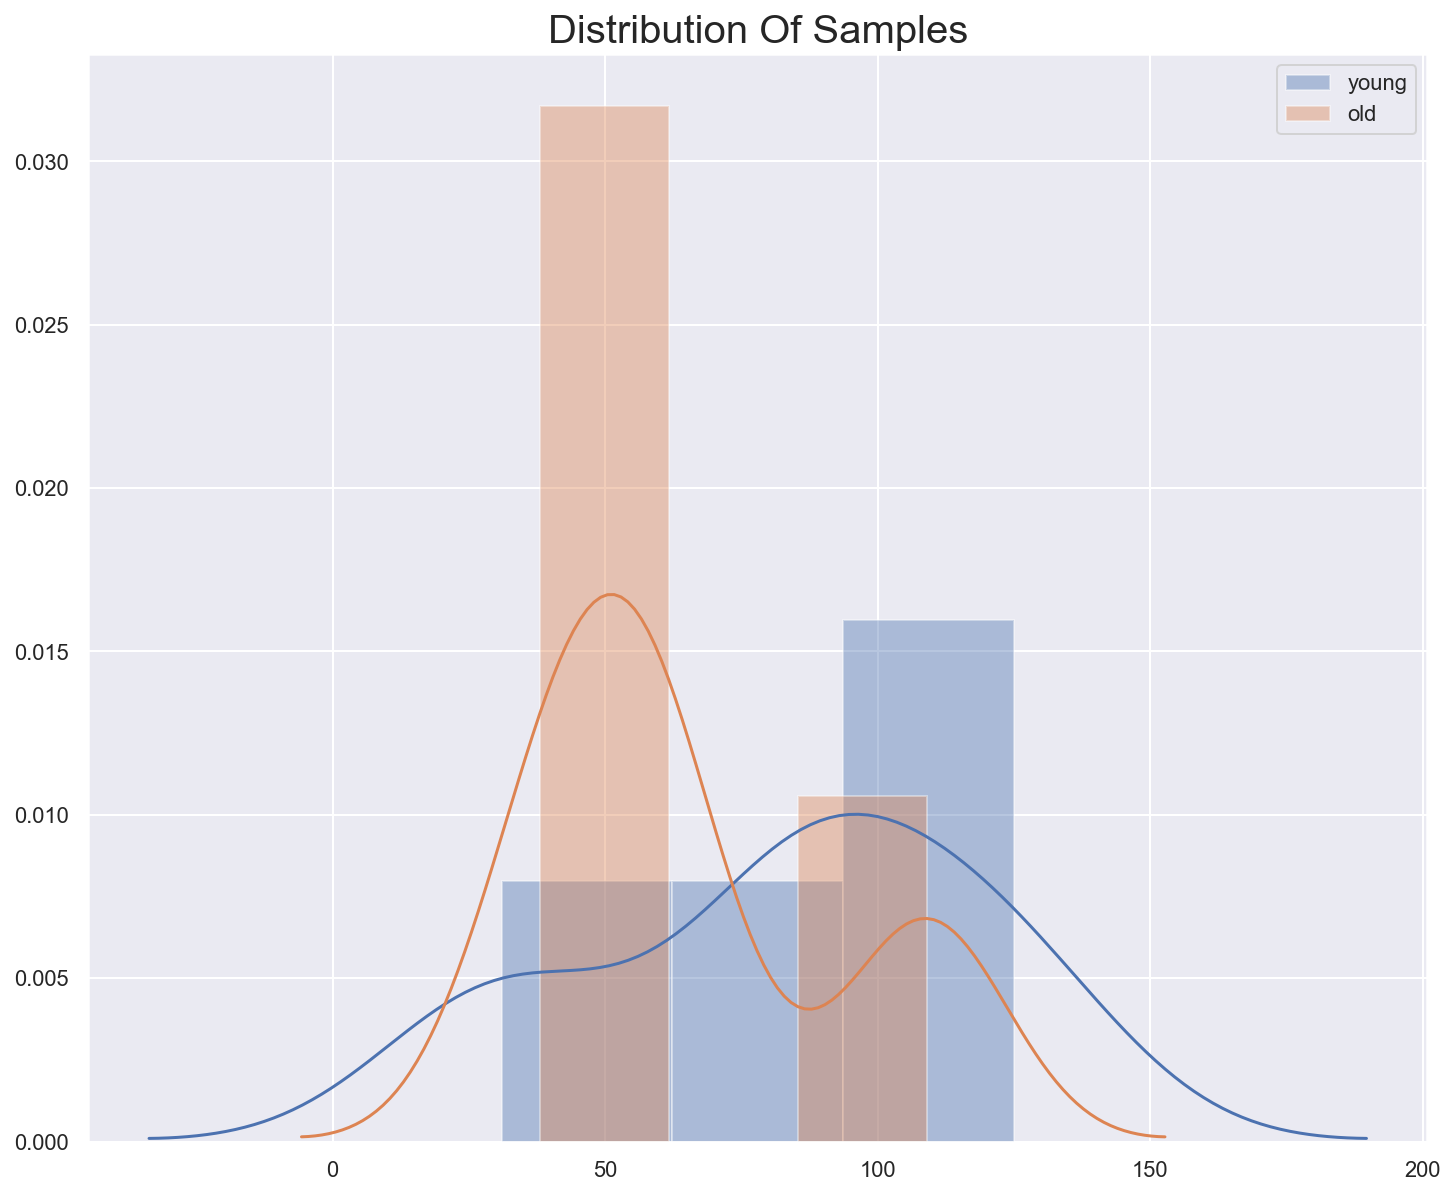

In [17]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(young, label='young')
sns.distplot(old, label='old') 
plt.title("Distribution Of Samples", size=20)
plt.legend()

In [18]:
# variance comparison

old.var(), young.var()

(712.5, 1168.1875)

#### The normality is not great and the variances are quite different.  I think we should use the Welch's t-test instead of the Student's t-test because it allows for unequal variances of the samples

### Results:

In [19]:
## To use the Welch statistic instead of the Student statistic, you have to set the equal_var paramter to false
stats.ttest_ind(young,old, equal_var=False)

Ttest_indResult(statistic=0.7288953457873759, pvalue=0.49506950217916734)

#### The p-value for our t-statistic of .729 is .495.  This is greater than our alpha of.05 so we ACCEPT the null hypothesis.  We are 95% sure there is no major difference in sales effectiveness by difference in age based on our samples

Even though the sample means are not very close to eachother (83 vs. 65) we were not even close to being able to reject the null hypothesis.  I think this is because we had so few data points to work with.  I didn't realize when I was first thinking about this question that the Northwind Database only had information for 9 sales employees.  

As it stands, I don't think this test was very useful due to the lack of data available. I think it could have been an informative question for the company had there between more information in the database on this subject.

# Third Hypothesis

### Is the average order amount (in money) greater when the sales employee is located in the same country as the buyer?

#### Null Hypo: no difference in average order amount
#### Alt Hypo:  difference in average order amount
(2-tailed, alpha=.05)

In [20]:
df = pd.read_sql_query("""
Select d.UnitPrice, d.Quantity, d.Discount, o.Id OrderId, 
o.ShipCountry CustomerCountry, e.Country EmployeeCountry
from [Order] o  join Employee e on o.EmployeeId = e.Id 
join OrderDetail d on d.OrderId = o.Id
where o.ShipCountry = e.Country
""", engine)
df.head()

,UnitPrice,Quantity,Discount,OrderId,CustomerCountry,EmployeeCountry
0,17.0,12,0.2,10262,USA,USA
1,24.0,15,0.0,10262,USA,USA
2,30.4,2,0.0,10262,USA,USA
3,8.0,30,0.0,10289,UK,UK
4,26.6,9,0.0,10289,UK,UK


### Preparation of Data for Hypothesis Testing Using Pandas

In [21]:
#calculate price for each sub-order and create new row for value

df['TotalMoney'] = round(df.UnitPrice * df.Quantity * (1-df.Discount),3)

In [22]:
#use a groupby (in Pandas) to combine all the sub-orders of each order to get the total price of each order
#the sum method does the addition
#store the series as an array for the hypothesis testing

same_country = np.array(df.groupby('OrderId', as_index=False)['TotalMoney'].sum()['TotalMoney'])

In [23]:
df = pd.read_sql_query("""
Select d.UnitPrice, d.Quantity, d.Discount, o.Id OrderId, 
o.ShipCountry CustomerCountry, e.Country EmployeeCountry
from [Order] o  join Employee e on o.EmployeeId = e.Id 
join OrderDetail d on d.OrderId = o.Id
where o.ShipCountry != e.Country
""", engine)
df.head()

,UnitPrice,Quantity,Discount,OrderId,CustomerCountry,EmployeeCountry
0,14.0,12,0.0,10248,France,UK
1,9.8,10,0.0,10248,France,UK
2,34.8,5,0.0,10248,France,UK
3,18.6,9,0.0,10249,Germany,UK
4,42.4,40,0.0,10249,Germany,UK


In [24]:
df['TotalMoney'] = round(df.UnitPrice * df.Quantity * (1-df.Discount),3)

In [25]:
diff_country = np.array(df.groupby('OrderId', as_index=False)['TotalMoney'].sum()['TotalMoney'])

In [26]:
#I think it's okay to do t-tests even when the samples have extremely unbalanced sizes

len(same_country), len(diff_country)

(108, 722)

## Distribution Of Samples

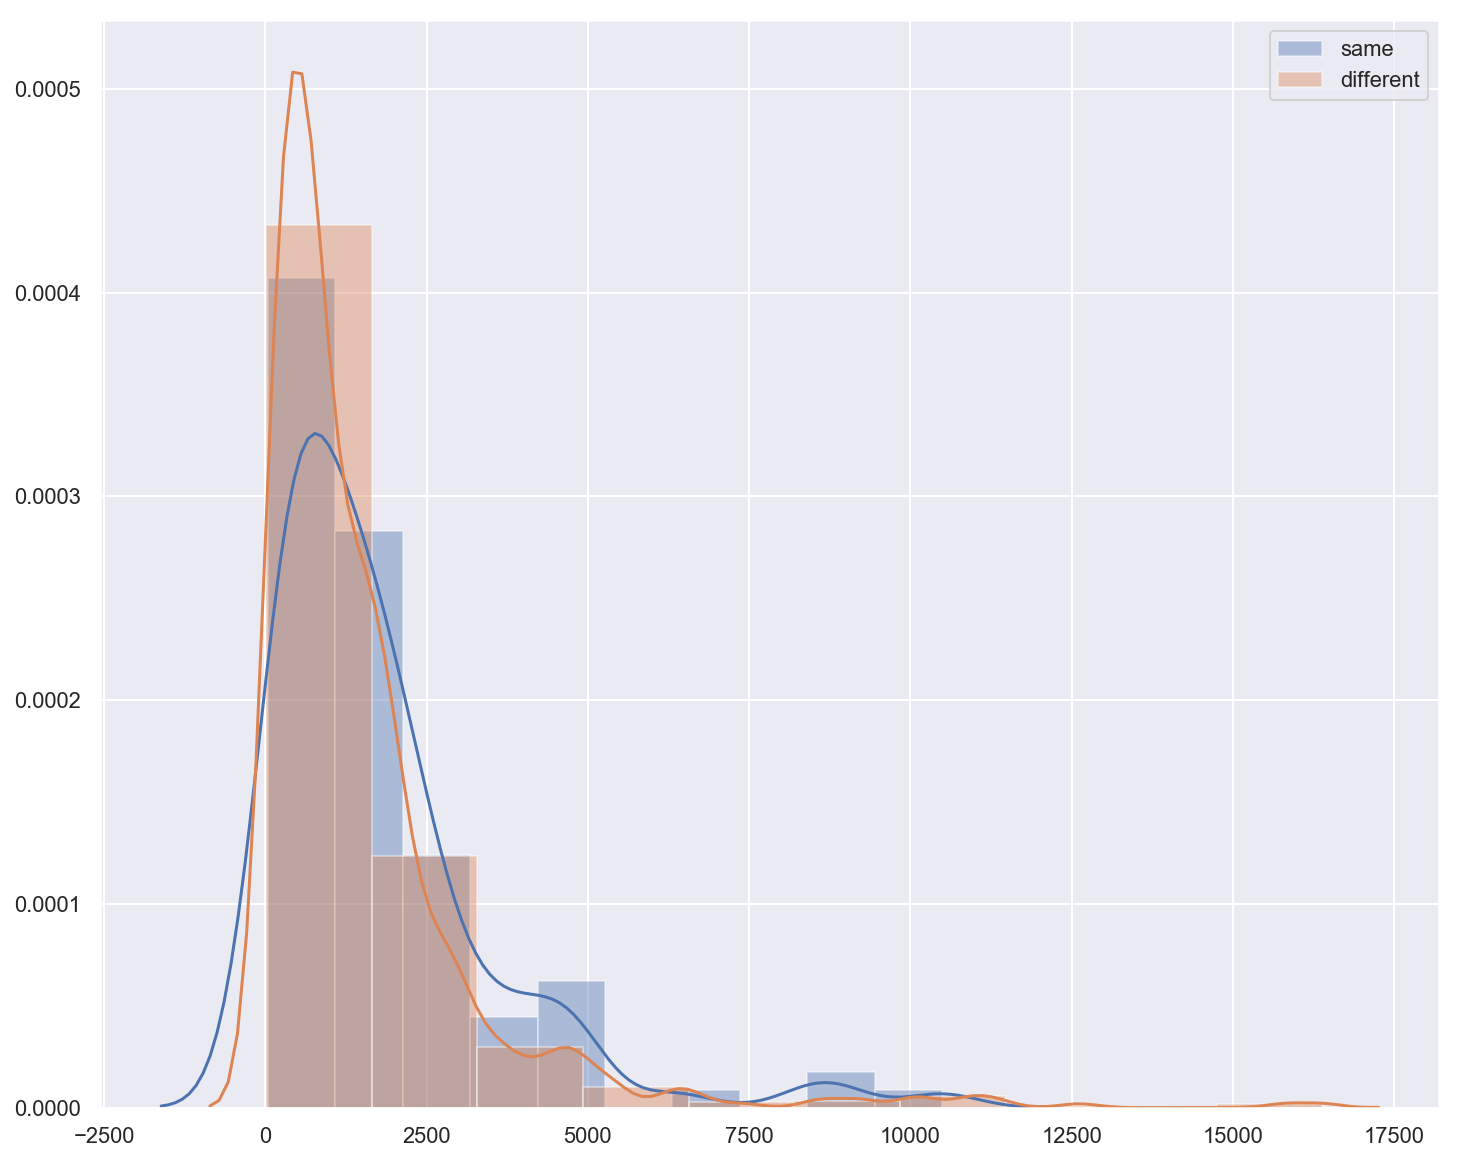

In [27]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(same_country, bins=10, label='same') 
sns.distplot(diff_country, bins=10, label='different') 
plt.legend()

#### The data is pretty normal except for outliers to the positive side of each.  I think it may be smart to cutoff the data at a certain point to make sure our data is normal so the t-test will be reliable

In [28]:
same_country = same_country[same_country<5500]

In [29]:
diff_country = diff_country[diff_country<5500]

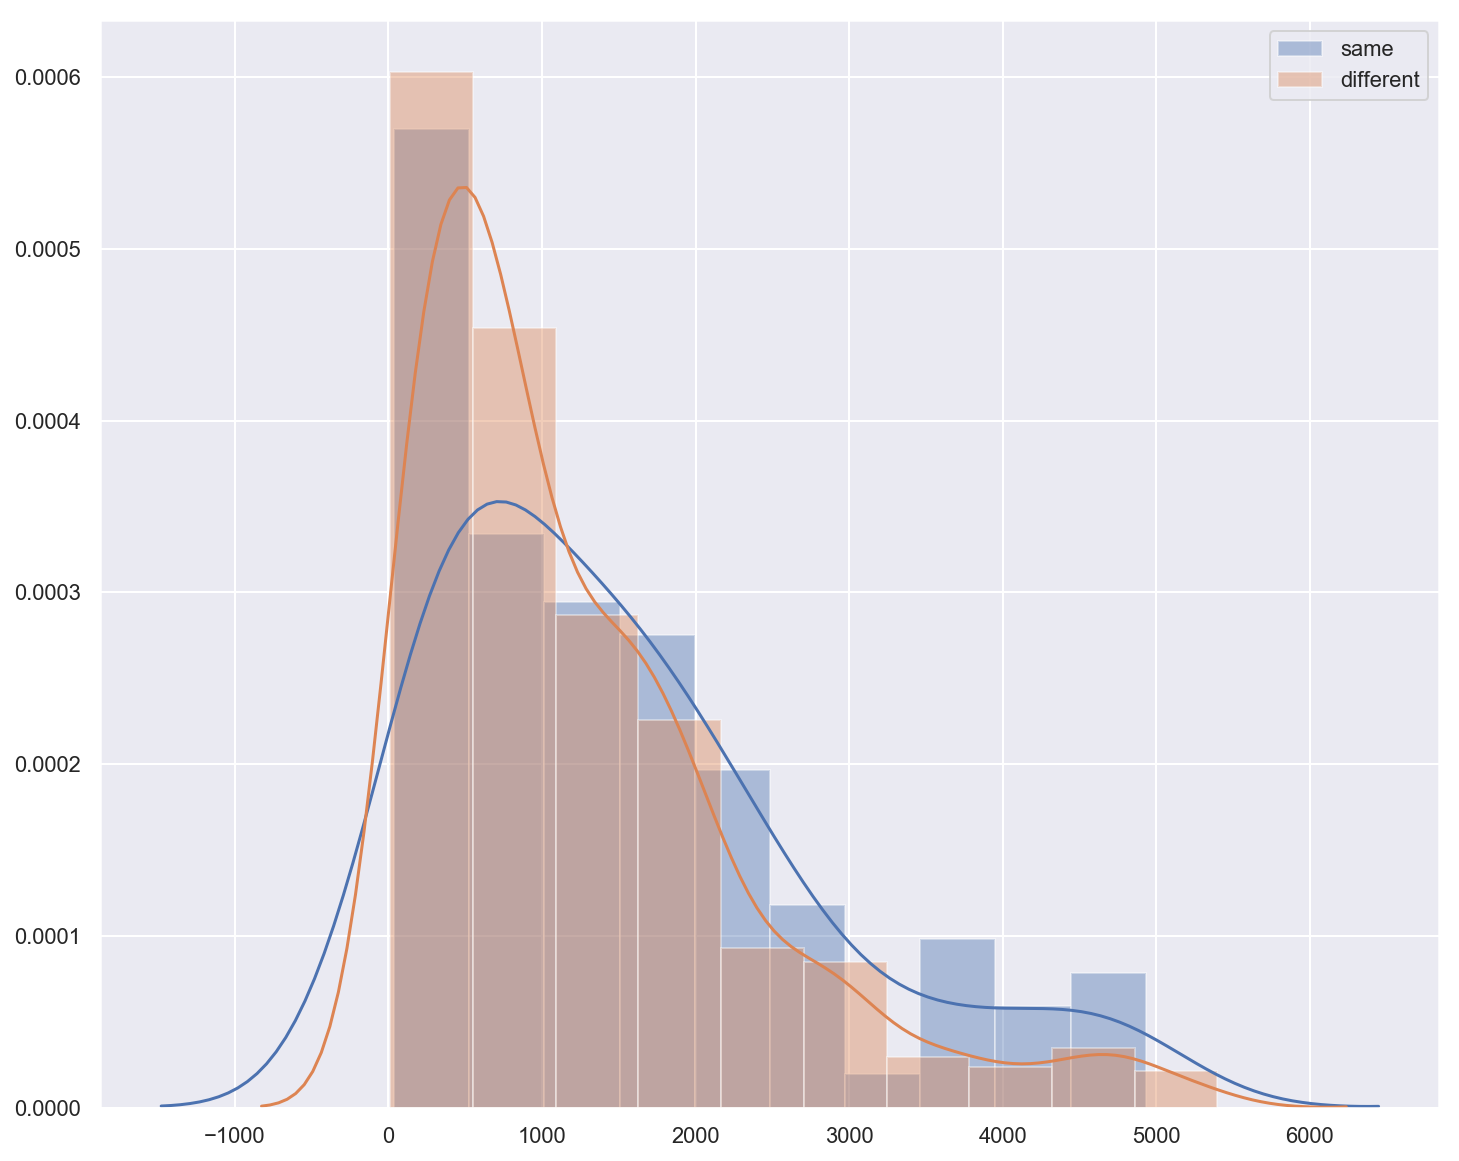

In [30]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(same_country, bins=10, label='same') 
sns.distplot(diff_country, bins=10, label='different') 
plt.legend()

### Null Hypo: no difference in average sale (price) between items sold to customers where both are located in same country vs where both are located in different countries

### Alt Hypo: there is a difference (in either direction)

Let's see how the variances of each sample compare to eachother to know what type of t-test to use (student's vs. welch)

In [31]:
same_country.var() , diff_country.var()

(1540979.951453233, 1188043.0242793628)

Hmm, not sure if this is too big of a difference to matter.  I'll just do both and see if there is any difference in results

In [32]:
same_country.mean(), diff_country.mean()

(1531.1159134615384, 1230.4987682403432)

### Results:

In [33]:
stats.ttest_ind(same_country, diff_country)

Ttest_indResult(statistic=2.571908616092002, pvalue=0.01029316070357537)

In [34]:
stats.ttest_ind(same_country, diff_country, equal_var=False)

Ttest_indResult(statistic=2.3288239395235437, pvalue=0.021441388099563214)

#### Both p-values are well less than our alpha of .05 so I think it's safe to reject the null hypothesis.  Our two samples give us evidence to suggest that the average sale price is higher when both parties are in the same country vs when not.  Business might be able to use this to determine which countries to add physical location(s) in

# 4th and Final Hypothesis

#### Let's look further at discounts in this dataset.  For this test, we will measure the average # of units in an order (by product).  Basically we want to see if people buy more of an item (at a time) when it is on sale vs. at full price

In [35]:
nodiscount_df_2 = pd.read_sql_query("""
Select *, avg(Quantity) avg_quant, count(*) data_points from OrderDetail 
where Discount = 0 group by ProductId order by ProductId
""", engine)

#only include products that have at least 5 data points (recorded orders for that product (at that price point))
##this is to reduce the chance of an outlier skewing the data

nodiscount_df_2 = nodiscount_df_2[nodiscount_df_2.data_points>4]
nodiscount_df_2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,avg_quant,data_points
0,10294/1,10294,1,14.4,18,0.0,17.772727,22
1,10255/2,10255,2,15.2,20,0.0,21.473684,19
2,10289/3,10289,3,8.0,30,0.0,28.800000,10
3,10309/4,10309,4,17.6,20,0.0,17.200000,10
4,10290/5,10290,5,17.0,20,0.0,29.333333,6


In [36]:
withdiscount_df = pd.read_sql_query("""
Select *, avg(Quantity) avg_quanty, count(*) data_points from OrderDetail 
where Discount > 0 group by ProductId order by ProductId
""", engine)
withdiscount_df = withdiscount_df[withdiscount_df.data_points>4]

#since we are comparing average order size by product, we have to make sure that if a product is represented in one sample
#it has to be represented in the other or that product is left out of the samples.  Product #48 existed in the
#discount sample but not the no_discount sample (because it did not have enough data points for our condition)
#so we had to drop that row of data to even the samples out

withdiscount_df = withdiscount_df.drop(withdiscount_df[withdiscount_df.ProductId==48].index)
withdiscount_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,avg_quanty,data_points
0,10285/1,10285,1,14.4,45,0.20,27.3125,16
1,10258/2,10258,2,15.2,50,0.20,25.9600,25
3,10336/4,10336,4,17.6,18,0.10,28.1000,10
6,10385/7,10385,7,24.0,10,0.20,16.8750,8
7,10344/8,10344,8,32.0,70,0.25,26.4000,5


In [37]:
#make the array from a Series for hypothesis testing
#using numpy's isin() on a pandas series, I'm basically using Python's built-in 'in' function to make sure each sample
#only has product info where product info exists in both samples

samp_no_discount = np.array(nodiscount_df_2[nodiscount_df_2.ProductId.isin(withdiscount_df['ProductId'])]['avg_quant'])

In [38]:
samp_yes_discount = np.array(withdiscount_df['avg_quanty'])

In [39]:
len(samp_no_discount), len(samp_yes_discount)

(63, 63)

## Distribution of Samples

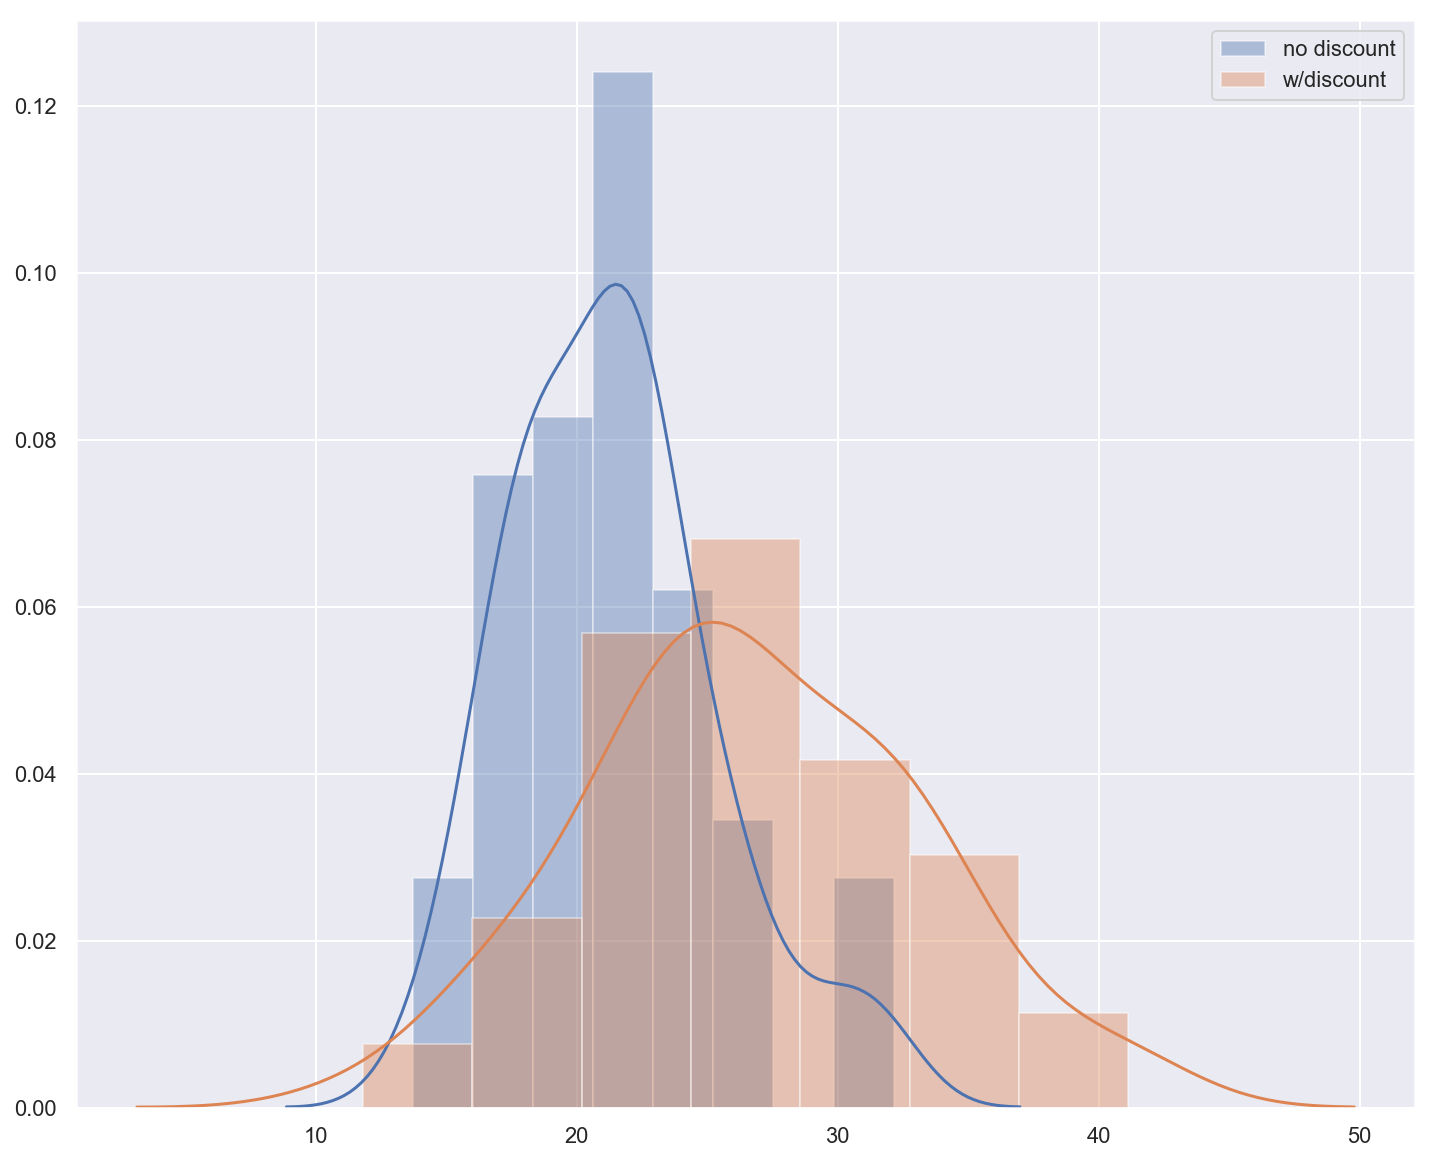

In [40]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(samp_no_discount, label='no discount')
sns.distplot(samp_yes_discount, label='w/discount') 
plt.legend()

### Results:

In [41]:
stats.ttest_ind(samp_no_discount, samp_yes_discount)

Ttest_indResult(statistic=-5.677698459996531, pvalue=9.169740416417652e-08)

### Null Hypothesis is easily rejected.  Discounts have a huge impact on how many orders are placed on a specific product at one time.  This makes a lot more sense than our original Hypothesis test on this subject. We now need to look into how each level of discount matters
# Extension

#### Each subsequent test measures the no_discount sample versus the sample where the Discount is exactly the value stated

### 5% Discount

In [42]:
withdiscount_df_5 = pd.read_sql_query("""
Select *, avg(Quantity) avg_quanty, count(*) data_points from OrderDetail 
where Discount = 0.05 group by ProductId order by ProductId
""", engine)
withdiscount_df_5 = withdiscount_df_5[withdiscount_df_5.data_points>1]
withdiscount_df_5.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,avg_quanty,data_points
1,10632/2,10632,2,19.0,30,0.05,16.666667,3
3,10871/6,10871,6,25.0,50,0.05,33.000000,2
4,10459/7,10459,7,24.0,16,0.05,13.000000,4
5,10273/10,10273,10,24.8,24,0.05,20.000000,3
6,10542/11,10542,11,21.0,15,0.05,15.000000,2


In [43]:
samp_no_discount_5test = np.array(nodiscount_df_2[nodiscount_df_2.ProductId.isin(withdiscount_df_5['ProductId'])]['avg_quant'])

In [44]:
samp_yes_discount_5test = np.array(withdiscount_df_5['avg_quanty'])

In [45]:
#this is just a check to make sure the samples are corresponded to each other correctly

len(samp_no_discount_5test), len(samp_yes_discount_5test), samp_no_discount_5test.mean(), samp_yes_discount_5test.mean()

(44, 45, 21.405960696965863, 28.3894708994709)

### Results:

In [46]:
stats.ttest_ind(samp_no_discount_5test, samp_yes_discount_5test)

Ttest_indResult(statistic=-3.130344161879004, pvalue=0.002377312663884809)

### Rejected the Null Hypothesis with a pvalue of .002.  So even at only a 5% discount there was a significant difference in average order size compared to the same item not discounted

## Effect Size

In [47]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [48]:
Cohen_d(samp_no_discount_5test, samp_yes_discount_5test)

-0.6712586162866624

### 10% Discount

In [49]:
withdiscount_df_10 = pd.read_sql_query("""
Select *, avg(Quantity) avg_quanty, count(*) data_points from OrderDetail where Discount = 0.10 
group by ProductId order by ProductId
""", engine)
withdiscount_df_10 = withdiscount_df_10[withdiscount_df_10.data_points>1]
withdiscount_df_10 = withdiscount_df_10.drop(withdiscount_df_10[withdiscount_df_10.ProductId==48].index)
withdiscount_df_10.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,avg_quanty,data_points
2,10485/3,10485,3,8.0,20,0.1,20.0,2
3,10336/4,10336,4,17.6,18,0.1,22.5,4
8,10688/10,10688,10,31.0,18,0.1,19.0,2
9,10535/11,10535,11,21.0,50,0.1,40.0,3
10,10291/13,10291,13,4.8,20,0.1,12.5,4


In [50]:
samp_no_discount_10test= np.array(nodiscount_df_2[nodiscount_df_2.ProductId.isin(withdiscount_df_10['ProductId'])]['avg_quant'])
samp_yes_discount_10test = np.array(withdiscount_df_10['avg_quanty'])
len(samp_no_discount_10test), len(samp_yes_discount_10test), samp_no_discount_10test.mean(), samp_yes_discount_10test.mean()

(45, 45, 21.078410582551165, 24.54216931216931)

### Results:

In [51]:
stats.ttest_ind(samp_no_discount_10test, samp_yes_discount_10test)

Ttest_indResult(statistic=-2.002917556304259, pvalue=0.048263623633464536)

#### With a pvalue of .48 we just barely were able to reject the Null Hypothesis.  The difference in means was less stark than for the 5% discount.  That's somewhat surprising

### Effect Size

In [52]:
Cohen_d(samp_no_discount_10test, samp_yes_discount_10test)

-0.4270234578052967

### 15% Discount

In [53]:
withdiscount_df_15 = pd.read_sql_query("""
Select *, avg(Quantity) avg_quanty, count(*) data_points from OrderDetail where Discount = 0.15 group by ProductId order by ProductId
""", engine)
withdiscount_df_15 = withdiscount_df_15[withdiscount_df_15.data_points>1]
withdiscount_df_15 = withdiscount_df_15.drop(withdiscount_df_15[withdiscount_df_15.ProductId==48].index)
withdiscount_df_15.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,avg_quanty,data_points
0,10348/1,10348,1,14.4,15,0.15,19.600000,5
1,10440/2,10440,2,15.2,45,0.15,25.000000,5
3,10511/7,10511,7,30.0,50,0.15,26.500000,2
4,10511/8,10511,8,40.0,10,0.15,15.000000,2
6,10664/10,10664,10,31.0,24,0.15,49.333333,3


In [54]:
samp_no_discount_15test = np.array(nodiscount_df_2[nodiscount_df_2.ProductId.isin(withdiscount_df_15['ProductId'])]['avg_quant'])
samp_yes_discount_15test = np.array(withdiscount_df_15['avg_quanty'])
len(samp_no_discount_15test), len(samp_yes_discount_15test), samp_no_discount_15test.mean(), samp_yes_discount_15test.mean()

(40, 40, 21.818650066401762, 26.91875)

### Results:

In [55]:
stats.ttest_ind(samp_no_discount_15test, samp_yes_discount_15test)

Ttest_indResult(statistic=-2.232076426076059, pvalue=0.028479272373399957)

#### With a pvalue of .028 we are easily able to reject the Null Hypo

### Effect Size

In [56]:
Cohen_d(samp_no_discount_15test, samp_yes_discount_15test)

-0.5054657751402939

### 20%

In [57]:
withdiscount_df_20 = pd.read_sql_query("""
Select *, avg(Quantity) avg_quanty, count(*) data_points from OrderDetail where Discount = 0.20 group by ProductId order by ProductId
""", engine)
withdiscount_df_20 = withdiscount_df_20[withdiscount_df_20.data_points>1]
withdiscount_df_20.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,avg_quanty,data_points
0,10285/1,10285,1,14.4,45,0.2,42.5,4
1,10258/2,10258,2,15.2,50,0.2,24.7,10
2,10464/4,10464,4,17.6,16,0.2,18.0,2
3,10258/5,10258,5,17.0,65,0.2,38.5,2
6,10357/10,10357,10,24.8,30,0.2,25.0,2


In [58]:
samp_no_discount_20test = np.array(nodiscount_df_2[nodiscount_df_2.ProductId.isin(withdiscount_df_20['ProductId'])]['avg_quant'])
samp_yes_discount_20test = np.array(withdiscount_df_20['avg_quanty'])
len(samp_no_discount_20test), len(samp_yes_discount_20test), samp_no_discount_20test.mean(), samp_yes_discount_20test.mean()

(45, 45, 21.014446021044616, 28.063333333333333)

### Results:

In [59]:
stats.ttest_ind(samp_no_discount_20test, samp_yes_discount_20test)

Ttest_indResult(statistic=-4.02751597257798, pvalue=0.00011926263718331566)

#### This the smallest pvalue yet for rejecting the Null Hypo.  Makes sense as a 20% discount is a lot of money saved 

### Effect Size

In [60]:
Cohen_d(samp_no_discount_20test, samp_yes_discount_20test)

-0.8586692904872885

### 25%

In [61]:
withdiscount_df_25 = pd.read_sql_query("""
Select *, avg(Quantity) avg_quanty, count(*) data_points from OrderDetail where Discount = 0.25 group by ProductId order by ProductId
""", engine)
withdiscount_df_25 = withdiscount_df_25[withdiscount_df_25.data_points>1]
withdiscount_df_25 = withdiscount_df_25.drop(withdiscount_df_25[withdiscount_df_25.ProductId==48].index)
withdiscount_df_25.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,avg_quanty,data_points
0,10646/1,10646,1,18.0,15,0.25,27.80,5
1,10393/2,10393,2,15.2,25,0.25,34.50,6
2,10913/4,10913,4,22.0,30,0.25,27.50,2
8,10489/11,10489,11,16.8,15,0.25,18.75,4
11,10393/14,10393,14,18.6,42,0.25,31.00,2


In [62]:
samp_no_discount_25test = np.array(nodiscount_df_2[nodiscount_df_2.ProductId.isin(withdiscount_df_25['ProductId'])]['avg_quant'])
samp_yes_discount_25test = np.array(withdiscount_df_25['avg_quanty'])
len(samp_no_discount_25test), len(samp_yes_discount_25test), samp_no_discount_25test.mean(), samp_yes_discount_25test.mean()

(38, 38, 20.94664847927541, 28.31472431077694)

### Results:

In [63]:
stats.ttest_ind(samp_no_discount_25test, samp_yes_discount_25test)

Ttest_indResult(statistic=-3.7506491864303517, pvalue=0.000347867397738462)

#### The difference in means is the greatest yet but because of the smaller sample sizes this pvalue is still ever so slightly bigger than for the 20% discount test

### Effect Size

In [64]:
Cohen_d(samp_no_discount_25test, samp_yes_discount_25test)

-0.8720082233579105

# Discount Review

Even though in general one would assume that an incremental increase in discount % would lead to increases in sales at each increment, I wasn't sure we would see that in our data.  Mostly because these are just limited sample sizes.  Over time and with enough data points I would expect our data to reflect that.

But our data mostly showed that too.  If you take out only the results from the test on 5% discounts, there was an increase in effect size (using Cohen's D) at each interval (10,15,20,25).  The 5% results showed greater increase in mean sales totals than 10 and 15 but significantly less than 20 and 25.

The effect sizes for 20 and 25 were both above .85  Slightly greater than what is considered a "large effect". So if I was this business trying to make policy from this data, I would make sure to have discounts 20 or 25 percent if I wanted to see good increase in average sales per order totals.  If I had to recommend 1 discount for being the most effective I would say the 20% discount.  Because there was hardly any difference in mean difference but you are saving the company 5% on each sale by having the discount at 20 instead of 25